# Extreme Learning Machine

## Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

## EML

In [2]:
class ELM(object):
    
    def __init__(self, Xtrain, ytrain, Xval, yval, n1):
        self.n1     = n1   #First hidden layer neuron quantity
        
        self.d       = ytrain.values
        self.x       = np.insert(Xtrain.values, 0, -1, axis = 1)
        self.dval    = yval.values
        self.xval    = np.insert(Xval.values, 0, -1, axis = 1)
        
        self.mse_      = []
        self.mse       = pd.DataFrame()
        self.mseval_   = []
        self.mseval    = pd.DataFrame()
        self.minmseval = 100000
        
        
        self.weight1 = np.random.rand(self.n1,self.x.shape[1])  
        self.weight2 = np.random.rand(self.d.shape[1],self.n1+1)          #+1 for the w0
        
        self.Xh = []

        
        #Activations functions and its derivates
    def tanh(self, val):
        return np.tanh(val)
    
    def logistic(self, val):
        return (1/(1+np.exp(-val)))
    
      
    #Forward step 
    def forward(self):        
        self.l1 = np.dot(self.xi,self.weight1.T)
        self.Y1 = np.insert(self.tanh(self.l1), 0, -1)
        self.Y1 = self.Y1.reshape(1,self.Y1.shape[0])
        self.l2 = np.dot(self.Y1, self.weight2.T)
        self.Y2 = self.tanh(self.l2)
        
        self.Xh.append(self.Y1[0])
        
    def PIMP(self):
        
        self.weight2 = np.dot(np.linalg.pinv(self.Xh), self.d)
        self.weight2 = self.weight2.T
       
         
    def predict(self,x,act_func):   
        self.pred_x = np.insert(x, 0, -1, axis = 1)
        self.pred = []
        for xi in self.pred_x:
            self.xi = xi
            self.forward()
            self.pred.append(self.Y2[0])
        
        if act_func == 'None':
            return self.pred
        
        elif act_func == 'Step':
            return self.step(self.pred)
        
        elif act_func == 'biStep':
            return self.biStep(self.pred)
    
    def validation(self):
        self.mseval_ = []
        for xi,di in zip(self.xval,self.dval):
            self.xi = xi
            self.di = di
            self.forward()
            error = (self.di-self.Y2[0])**2
            self.mseval_.append(np.sum(error))   
            
        self.MSE('val')
    
    def MSE(self,train_val):
        
        if train_val == 'train':
            error    = np.array(self.mse_)/2
            error    = error.mean()
            error    = pd.DataFrame([error])
            self.mse = pd.concat((self.mse,error))
        
        elif train_val == 'val':
            error       = np.array(self.mseval_)/2
            error       = error.mean()
            error       = pd.DataFrame([error])
            self.mseval = pd.concat((self.mseval,error))
    
    
    def fit(self):
        self.mse_    = []
        for xi,di in zip(self.x,self.d):
            self.xi = xi
            self.di = di
            self.forward()
            
        self.PIMP()
        error = (self.di-self.Y2[0])**2
        self.mse_.append(np.sum(error))
                  
        self.MSE('train')
        self.validation()
            
    
    def step(self, y):
        return (pd.DataFrame(y)>=0)*1
    
    def biStep(self, y):
        return ((pd.DataFrame(y)>=0)*1).replace(0,-1)

## IRIS AND WINE

### Data loading and normalizing

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, classification_report

In [5]:
def norm(x):
    xmin = x.min()
    xmax = x.max()
    x = np.array(x)
    x = -1 + (2*((x-xmin)/(xmax-xmin)))
    return x

In [6]:
from sklearn.datasets import load_iris, load_wine

In [7]:
iris = load_iris()
wine = load_wine()

In [8]:
iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_df[iris.target_names] = pd.get_dummies(iris.target).astype(np.int).replace(0,-1)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,1,-1,-1
1,4.9,3.0,1.4,0.2,1,-1,-1
2,4.7,3.2,1.3,0.2,1,-1,-1
3,4.6,3.1,1.5,0.2,1,-1,-1
4,5.0,3.6,1.4,0.2,1,-1,-1


In [9]:
iris_df_norm = pd.DataFrame(data=iris.data,columns=iris.feature_names).apply(norm, axis=0, result_type='broadcast',raw=True)
iris_df_norm[iris.target_names] = pd.get_dummies(iris.target).astype(np.int).replace(0,-1)
iris_df_norm.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),setosa,versicolor,virginica
0,-0.555556,0.250000,-0.864407,-0.916667,1,-1,-1
1,-0.666667,-0.166667,-0.864407,-0.916667,1,-1,-1
2,-0.777778,0.000000,-0.898305,-0.916667,1,-1,-1
3,-0.833333,-0.083333,-0.830508,-0.916667,1,-1,-1
4,-0.611111,0.333333,-0.864407,-0.916667,1,-1,-1


In [10]:
wine_df = pd.DataFrame(data=wine.data,columns=wine.feature_names)
wine_df[wine.target_names] = pd.get_dummies(wine.target).astype(np.int).replace(0,-1)
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class_0,class_1,class_2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1,-1,-1
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1,-1,-1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1,-1,-1
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1,-1,-1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1,-1,-1


In [11]:
wine_df_norm = pd.DataFrame(data=wine.data,columns=wine.feature_names).apply(norm, axis=0, result_type='broadcast',raw=True)
wine_df_norm[wine.target_names] = pd.get_dummies(wine.target).astype(np.int).replace(0,-1)
wine_df_norm.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class_0,class_1,class_2
0,0.684211,-0.616601,0.144385,-0.484536,0.239130,0.255172,0.147679,-0.433962,0.186120,-0.255973,-0.089431,0.941392,0.122682,1,-1,-1
1,0.142105,-0.588933,-0.165775,-0.938144,-0.347826,0.151724,0.021097,-0.509434,-0.451104,-0.470990,-0.073171,0.560440,0.101284,1,-1,-1
2,0.121053,-0.359684,0.401070,-0.175258,-0.326087,0.255172,0.223629,-0.358491,0.514196,-0.249147,-0.105691,0.391941,0.293866,1,-1,-1
3,0.757895,-0.521739,0.219251,-0.360825,-0.065217,0.979310,0.329114,-0.584906,0.116719,0.112628,-0.382114,0.597070,0.714693,1,-1,-1
4,0.163158,-0.268775,0.614973,0.072165,0.043478,0.255172,-0.008439,-0.018868,-0.110410,-0.481229,-0.089431,0.216117,-0.348074,1,-1,-1


### Training and Assessment

### IRIS

In [12]:
# Spliting the indexes, because there are two different dataframes, normalized and not normalized

#Iris
Xtrain_iris_i, Xval_iris_i, ytrain_iris_i, yval_iris_i = train_test_split(range(iris_df.shape[0]),range(iris_df.shape[0]),
                                                    test_size=0.3)



In [13]:
Xtrain_iris = iris_df_norm[iris.feature_names].iloc[Xtrain_iris_i]
ytrain_iris = iris_df_norm[iris.target_names].iloc[ytrain_iris_i]
Xval_iris   = iris_df_norm[iris.feature_names].iloc[Xval_iris_i]
yval_iris   = iris_df_norm[iris.target_names].iloc[yval_iris_i]

In [14]:
Xtest_iris = Xval_iris
ytest_iris = yval_iris
ytest_iris.replace(-1,0,inplace=True)

In [15]:
print('Dados treino:')
print(np.str(ytrain_iris.replace(-1,0).sum()))
print('\nDados validação:')
print(np.str(yval_iris.replace(-1,0).sum()))
print('\nDados teste:')
print(np.str(ytest_iris.sum()))

Dados treino:
setosa        38
versicolor    33
virginica     34
dtype: int64

Dados validação:
setosa        12
versicolor    17
virginica     16
dtype: int64

Dados teste:
setosa        12
versicolor    17
virginica     16
dtype: int64


In [115]:
boxplot = pd.DataFrame()

###### 1 Neuron

In [81]:
mse_elm      = pd.DataFrame()
mseval_elm   = pd.DataFrame()
cla_report   = []

for i in np.arange(1,11,1):
    elm = ELM(Xtrain=Xtrain_iris, ytrain=ytrain_iris, Xval=Xval_iris, yval=yval_iris, n1=1)
    elm.fit()
    
    mse_elm[np.str(i)]    = elm.mse.reset_index()[0]
    mseval_elm[np.str(i)] = elm.mseval.reset_index()[0]
 
    y = pd.DataFrame(elm.predict(Xtest_iris.values, act_func='biStep').values,columns=iris.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_iris, y_pred=y))
    
    print('Run: '+np.str(i))

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\

In [82]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.00      0.00      0.00        17
           2       0.92      0.75      0.83        16

   micro avg       0.75      0.53      0.62        45
   macro avg       0.52      0.58      0.53        45
weighted avg       0.50      0.53      0.50        45
 samples avg       0.53      0.53      0.53        45

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.00      0.00      0.00        17
           2       0.86      0.75      0.80        16

   micro avg       0.73      0.53      0.62        45
   macro avg       0.50      0.58      0.52        45
weighted avg       0.47      0.53      0.49        45
 samples avg       0.53  

Text(0, 0.5, 'MSE')

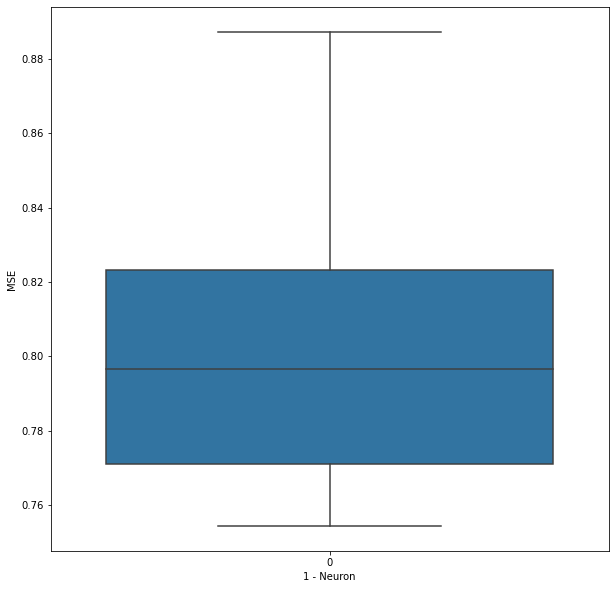

In [83]:
plt.figure(figsize = (10,10))
sns.boxplot(data=mseval_elm.T)
plt.xlabel('1 - Neuron')
plt.ylabel('MSE')

In [101]:
boxplot = pd.concat((boxplot, mseval_elm.T), ignore_index=True, axis=1)

###### 10 Neurons

In [102]:
mse_elm      = pd.DataFrame()
mseval_elm   = pd.DataFrame()
cla_report   = []

for i in np.arange(1,11,1):
    elm = ELM(Xtrain=Xtrain_iris, ytrain=ytrain_iris, Xval=Xval_iris, yval=yval_iris, n1=10)
    elm.fit()
    
    mse_elm[np.str(i)]    = elm.mse.reset_index()[0]
    mseval_elm[np.str(i)] = elm.mseval.reset_index()[0]
 
    y = pd.DataFrame(elm.predict(Xtest_iris.values, act_func='biStep').values,columns=iris.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_iris, y_pred=y))
    
    print('Run: '+np.str(i))

C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


In [103]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.87      0.76      0.81        17
           2       0.83      0.94      0.88        16

   micro avg       0.89      0.89      0.89        45
   macro avg       0.90      0.90      0.90        45
weighted avg       0.89      0.89      0.89        45
 samples avg       0.88      0.89      0.88        45

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.94      1.00      0.97        17
           2       0.89      1.00      0.94        16

   micro avg       0.94      1.00      0.97        45
   macro avg       0.94      1.00      0.97        45
weighted avg       0.94      1.00      0.97        45
 samples avg       0.97  

Text(0, 0.5, 'MSE')

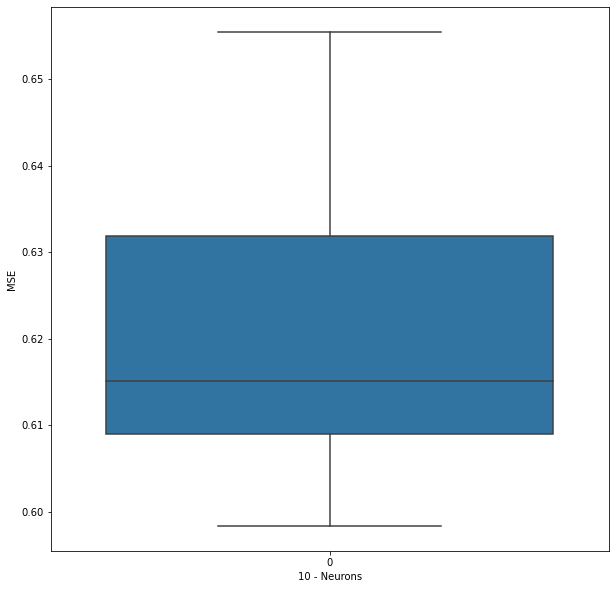

In [104]:
plt.figure(figsize = (10,10))
sns.boxplot(data=mseval_elm.T)
plt.xlabel('10 - Neurons')
plt.ylabel('MSE')

In [105]:
boxplot = pd.concat((boxplot, mseval_elm.T), ignore_index=True, axis=1)

###### 50 Neurons

In [106]:
mse_elm      = pd.DataFrame()
mseval_elm   = pd.DataFrame()
cla_report   = []

for i in np.arange(1,11,1):
    elm = ELM(Xtrain=Xtrain_iris, ytrain=ytrain_iris, Xval=Xval_iris, yval=yval_iris, n1=50)
    elm.fit()
    
    mse_elm[np.str(i)]    = elm.mse.reset_index()[0]
    mseval_elm[np.str(i)] = elm.mseval.reset_index()[0]
 
    y = pd.DataFrame(elm.predict(Xtest_iris.values, act_func='biStep').values,columns=iris.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_iris, y_pred=y))
    
    print('Run: '+np.str(i))

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      0.82      0.87        17
           2       0.83      0.94      0.88        16

   micro avg       0.91      0.91      0.91        45
   macro avg       0.92      0.92      0.92        45
weighted avg       0.92      0.91      0.91        45
 samples avg       0.91      0.91      0.91        45

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.82      0.82      0.82        17
           2       0.81      0.81      0.81        16

   micro avg       0.87      0.87      0.87        45
   macro avg       0.88      0.88      0.88        45
weighted avg       0.87      0.87      0.87        45
 samples avg       0.87  

Text(0, 0.5, 'MSE')

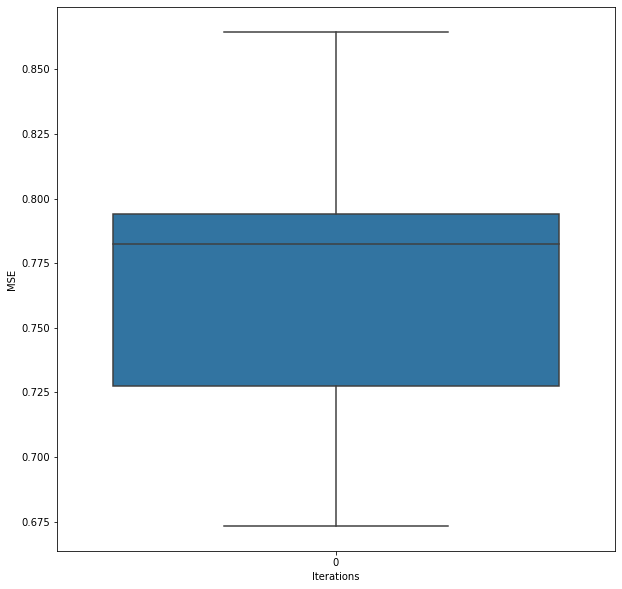

In [108]:
plt.figure(figsize = (10,10))
sns.boxplot(data=mseval_elm.T)
plt.xlabel('Iterations')
plt.ylabel('MSE')

In [109]:
boxplot = pd.concat((boxplot, mseval_elm.T), ignore_index=True, axis=1)

In [112]:
a = pd.DataFrame(boxplot.values, columns=['1N', '10N', '50N'])

Text(0, 0.5, 'MSE')

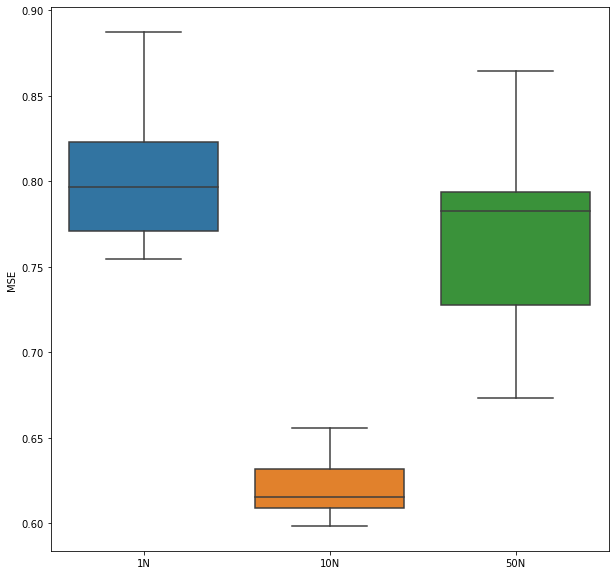

In [114]:
a = pd.DataFrame(boxplot.values, columns=['1N', '10N', '50N'])
plt.figure(figsize = (10,10))
sns.boxplot(data=a)
plt.ylabel('MSE')

### WINE

In [124]:
Xtrain_wine_i, Xval_wine_i, ytrain_wine_i, yval_wine_i = train_test_split(range(wine_df.shape[0]),range(wine_df.shape[0]),
                                                    test_size=0.3)


In [125]:
Xtrain_wine = wine_df_norm[wine.feature_names].iloc[Xtrain_wine_i]
ytrain_wine = wine_df_norm[wine.target_names].iloc[ytrain_wine_i]
Xval_wine   = wine_df_norm[wine.feature_names].iloc[Xval_wine_i]
yval_wine   = wine_df_norm[wine.target_names].iloc[yval_wine_i]

In [126]:
Xtest_wine = Xval_wine
ytest_wine = yval_wine
ytest_wine.replace(-1,0,inplace=True)

In [127]:
print('Dados treino:')
print(np.str(ytrain_wine.replace(-1,0).sum()))
print('\nDados validação:')
print(np.str(yval_wine.replace(-1,0).sum()))
print('\nDados teste:')
print(np.str(ytest_wine.sum()))

Dados treino:
class_0    40
class_1    49
class_2    35
dtype: int64

Dados validação:
class_0    19
class_1    22
class_2    13
dtype: int64

Dados teste:
class_0    19
class_1    22
class_2    13
dtype: int64


### 1 Neuron

In [134]:
mse_elm      = pd.DataFrame()
mseval_elm   = pd.DataFrame()
cla_report   = []

for i in np.arange(1,11,1):
    elm = ELM(Xtrain=Xtrain_wine, ytrain=ytrain_wine, Xval=Xval_wine, yval=yval_wine, n1=1)
    elm.fit()
    
    mse_elm[np.str(i)]    = elm.mse.reset_index()[0]
    mseval_elm[np.str(i)] = elm.mseval.reset_index()[0]
 
    y = pd.DataFrame(elm.predict(Xtest_wine.values, act_func='biStep').values,columns=wine.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_wine, y_pred=y))   

C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\

In [135]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.58      0.69        19
           1       0.76      0.86      0.81        22
           2       0.00      0.00      0.00        13

   micro avg       0.79      0.56      0.65        54
   macro avg       0.54      0.48      0.50        54
weighted avg       0.61      0.56      0.57        54
 samples avg       0.56      0.56      0.56        54

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.53      0.65        19
           1       0.89      0.73      0.80        22
           2       0.00      0.00      0.00        13

   micro avg       0.87      0.48      0.62        54
   macro avg       0.57      0.42      0.48        54
weighted avg       0.66      0.48      0.55        54
 samples avg       0.48  

Text(0, 0.5, 'MSE')

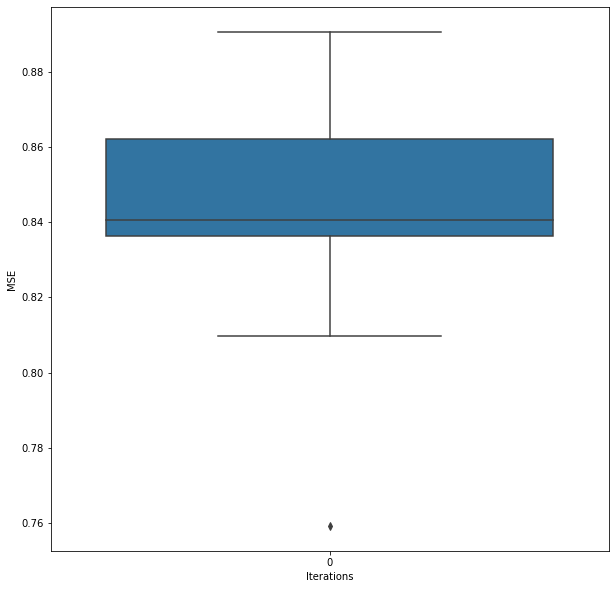

In [136]:
plt.figure(figsize = (10,10))
sns.boxplot(data=mseval_elm.T)
plt.xlabel('Iterations')
plt.ylabel('MSE')

In [137]:
boxplot = pd.concat((boxplot, mseval_elm.T), ignore_index=True, axis=1)

### 10 Neurons

In [138]:
mse_elm      = pd.DataFrame()
mseval_elm   = pd.DataFrame()
cla_report   = []

for i in np.arange(1,11,1):
    elm = ELM(Xtrain=Xtrain_wine, ytrain=ytrain_wine, Xval=Xval_wine, yval=yval_wine, n1=10)
    elm.fit()
    
    mse_elm[np.str(i)]    = elm.mse.reset_index()[0]
    mseval_elm[np.str(i)] = elm.mseval.reset_index()[0]
 
    y = pd.DataFrame(elm.predict(Xtest_wine.values, act_func='biStep').values,columns=wine.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_wine, y_pred=y))   

C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\

In [139]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        19
           1       0.67      0.73      0.70        22
           2       1.00      0.69      0.82        13

   micro avg       0.81      0.65      0.72        54
   macro avg       0.89      0.65      0.73        54
weighted avg       0.86      0.65      0.72        54
 samples avg       0.65      0.65      0.65        54

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.83      0.91      0.87        22
           2       0.91      0.77      0.83        13

   micro avg       0.88      0.85      0.87        54
   macro avg       0.89      0.84      0.86        54
weighted avg       0.89      0.85      0.87        54
 samples avg       0.83  

Text(0, 0.5, 'MSE')

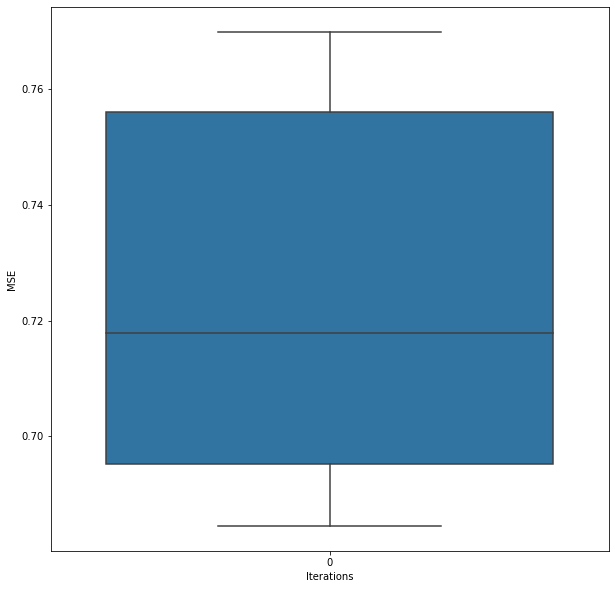

In [140]:
plt.figure(figsize = (10,10))
sns.boxplot(data=mseval_elm.T)
plt.xlabel('Iterations')
plt.ylabel('MSE')

In [141]:
boxplot = pd.concat((boxplot, mseval_elm.T), ignore_index=True, axis=1)

### 50 Neurons

In [148]:
mse_elm      = pd.DataFrame()
mseval_elm   = pd.DataFrame()
cla_report   = []

for i in np.arange(1,11,1):
    elm = ELM(Xtrain=Xtrain_wine, ytrain=ytrain_wine, Xval=Xval_wine, yval=yval_wine, n1=50)
    elm.fit()
    
    mse_elm[np.str(i)]    = elm.mse.reset_index()[0]
    mseval_elm[np.str(i)] = elm.mseval.reset_index()[0]
 
    y = pd.DataFrame(elm.predict(Xtest_wine.values, act_func='biStep').values,columns=wine.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_wine, y_pred=y))   

C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\

In [149]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       0.80      0.91      0.85        22
           2       0.86      0.92      0.89        13

   micro avg       0.85      0.94      0.89        54
   macro avg       0.85      0.94      0.90        54
weighted avg       0.85      0.94      0.89        54
 samples avg       0.89      0.94      0.91        54

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.76      0.73      0.74        22
           2       0.63      0.92      0.75        13

   micro avg       0.77      0.81      0.79        54
   macro avg       0.78      0.83      0.79        54
weighted avg       0.79      0.81      0.80        54
 samples avg       0.77  

Text(0, 0.5, 'MSE')

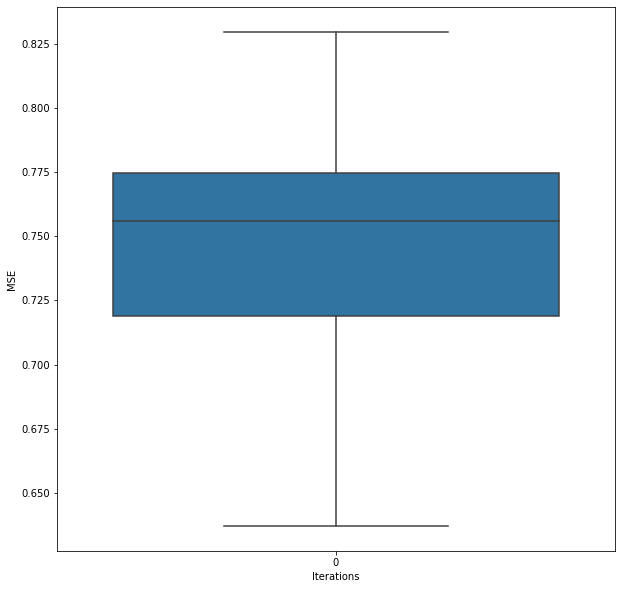

In [150]:
plt.figure(figsize = (10,10))
sns.boxplot(data=mseval_elm.T)
plt.xlabel('Iterations')
plt.ylabel('MSE')

In [151]:
boxplot = pd.concat((boxplot, mseval_elm.T), ignore_index=True, axis=1)

Text(0, 0.5, 'MSE')

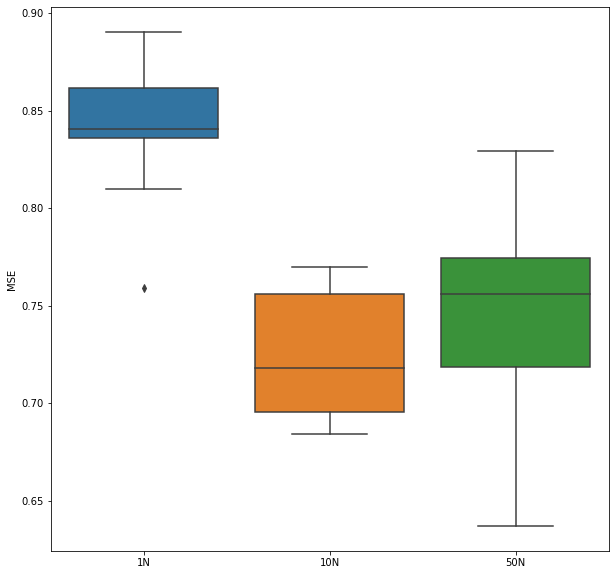

In [152]:
a = pd.DataFrame(boxplot.values, columns=['1N', '10N', '50N'])
plt.figure(figsize = (10,10))
sns.boxplot(data=a)
plt.ylabel('MSE')